In [44]:
import scipy
import numpy as np
from fitters import *
from tools import *
from matplotlib.pyplot import figure
set_seaborn()
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
def preprocess(signal, downsample=1):
    mean = np.mean(signal, axis=0)
    down = mean[::downsample]
    return down


In [46]:
def build_train_test_hankels(X, Y, dim, test_start, train_test_ratio):

    start = int(len(X) * test_start)
    end = start + int(len(X) * train_test_ratio)

    X_test, Y_test = X[start:end],  Y[start:end]
    X_train, Y_train = X.copy(), Y.copy()

    X_test = normalize(X_test)
    X_train = normalize(X_train)
    Y_test = normalize(Y_test)
    Y_train = normalize(Y_train)

    # use to remove from hankel later
    X_train[start:end] = np.nan
    
    # remove the beginning for causal convoltuion
    Y_train = np.delete(Y_train, np.arange(0,dim))
    Y_test = np.delete(Y_test, np.arange(0,dim))

    test_hankel = build_hankel(X_test, dim)
    train_hankel = build_hankel(X_train, dim)

    # remove lag vector with nan
    nan_cols = np.bitwise_or.reduce(np.isnan(train_hankel),0)
    # print(np.count_nonzero(nan_cols))

    train_hankel = np.delete(train_hankel, nan_cols, axis=1)
    Y_train = np.delete(Y_train, nan_cols)

    return train_hankel, Y_train, test_hankel, Y_test

def train_test_method(X, Y, model, dim, train_test_ratio=0.2, betas=np.arange(0,30,1)):

    test_start_range = np.linspace(0.0, 1.0-train_test_ratio, 100)
    T = len(test_start_range)
    B = len(betas)

    train_errors = np.zeros((B,T))
    test_errors = np.zeros((B,T))
    filters = np.zeros((B,T,dim))
    all_params = np.zeros((B,T), dtype='O')
    for t, test_start in enumerate(test_start_range):
        
        train_hankel, Y_train, test_hankel, Y_test = build_train_test_hankels(X, Y, dim, test_start, train_test_ratio)
        for b, beta in enumerate(betas):
            
            P_train, theta, params = model.train(train_hankel, Y_train, dim, beta=beta)
            P_test = model.test(test_hankel, theta, params)

            train_err = mean_square_error(Y_train, P_train)
            test_err = mean_square_error(Y_test, P_test)

            train_errors[b,t] = train_err
            test_errors[b,t] = test_err
            filters[b,t,:] = theta
            all_params[b,t] = params

    return train_errors, test_errors, filters, all_params, betas


In [64]:
class Results:
    def __init__(self, name, train_errors, test_errors, filters, params, betas ):
        self.name = name
        self.train_errors = train_errors
        self.test_errors = test_errors
        self.params = params
        self.filters = filters
        self.betas = betas

    def get_mean_and_stds(self, x):
        return np.mean(x, axis=1), np.std(x, axis=1)

    def get_train_errs(self):
        return self.get_mean_and_stds(self.train_errors)

    def get_test_errs(self):
        return self.get_mean_and_stds(self.test_errors)

    def get_opt_filter(self):
        opt_i = np.argmin(np.mean(self.train_errors, axis=1))
        opt_f = self.filters[opt_i]
        return (np.mean(opt_f, axis=0), np.std(opt_f, axis=0)), self.betas[opt_i]

    def get_params(self):
        num_params = len(self.params[0][0])
        remaped_params = []
        for n in range(num_params):
            p = np.zeros_like(self.params)
            for i in range(self.params.shape[0]):
                for j in range(self.params.shape[1]):
                    p[i,j] = self.params[i,j][n]
            remaped_params.append(p)

        return tuple(remaped_params)
        
        



In [65]:
def plot_beta_errs(results, train=True, test=True, title=''):

    if train:
        for i, result in enumerate(results):
            betas, errs, l = result.betas, result.get_train_errs(), result.name
            plt.errorbar(betas, *errs, label=l)

        plt.legend(); plt.xlabel('Beta'); plt.title(f'{title} Train Error')
        plt.show()

    if test:
        for i, result in enumerate(results):
            betas, errs, l = result.betas, result.get_test_errs(), result.name
            plt.errorbar(betas, *errs, label=l)

        plt.legend(); plt.xlabel('Beta'); plt.title(f'{title} Test Error')
        plt.show()


def plot_params(result):
    params = result.get_params()
    for i,p in enumerate(params):
        dist = p.flatten()
        plt.hist(dist, bins=len(dist)//100)
        plt.title(f'{result.name} Param {i}')
        plt.show()


def plot_filter(result):
    filter_mean_std, beta = result.get_opt_filter()
    figure(figsize = (8, 8), dpi = 80)
    d = len(filter_mean_std[0])
    plt.errorbar(np.linspace(0,d,d), *filter_mean_std)
    plt.title(f'{result.name} Optimal Filter for beta={beta}')
    plt.show()


In [66]:
resPH, stimPH = read_lmc('PHOTO')
res3, stim3 = read_lmc('LMC-BG3')
res4, stim4 = read_lmc('LMC-BG4')
res5, stim5 = read_lmc('LMC-BG5')
res6, stim6 = read_lmc('LMC-BG6')

In [67]:
title = 'LMC-BG4'
down = 10
X = preprocess(resPH, downsample=down)
Y = preprocess(res4, downsample=down)
dim = 50


# model = ConstantModel('Constant d=1')
# res = train_test_method(X, Y, model, 1)
# C1_Results = Results(model.name, *res)

# model = ConstantModel('Constant d=8')
# res = train_test_method(X, Y, model, 8)
# C8_Results = Results(model.name, *res)

# model = ConstantModel('Constant d=50')
# res = train_test_method(X, Y, model, 50)
# C50_Results = Results(model.name, *res)


# model = LinearModel('Linear 100')
# res = train_test_method(X, Y, model, 100)
# Lin100_Results = Results(model.name, *res)

# model = EigenModel('Eigen 100')
# res = train_test_method(X, Y, model, 100)
# Eig100_Results = Results(model.name, *res)

model = ConstantModel('Constant d=2')
res = train_test_method(X, Y, model, 2)
C2_Results = Results(model.name, *res)

model = LinearModel('Linear 50')
res = train_test_method(X, Y, model, 50)
Lin50_Results = Results(model.name, *res)

model = EigenModel('Eigen 50')
res = train_test_method(X, Y, model, 50)
Eig50_Results = Results(model.name, *res)


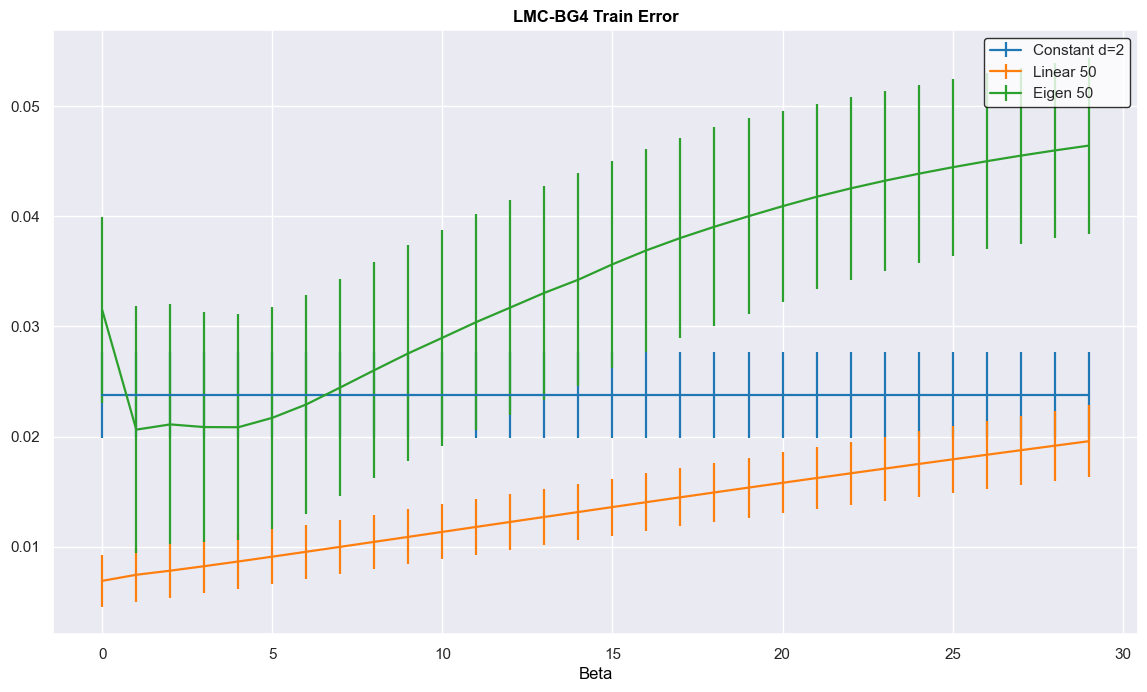

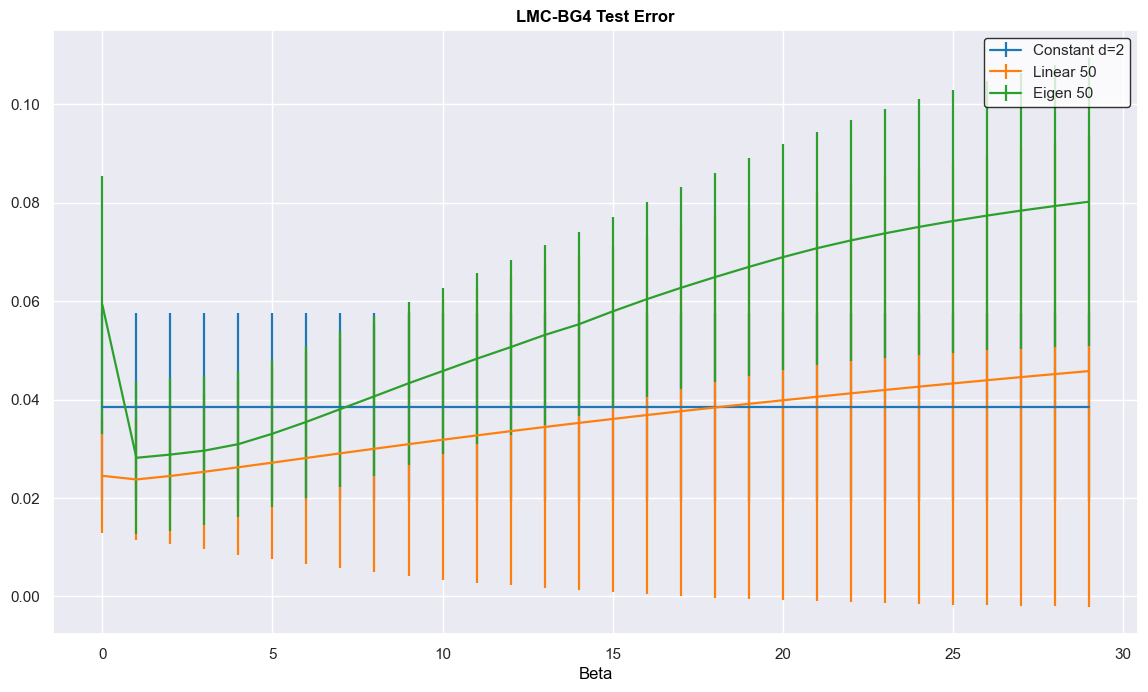

In [68]:

# all_results = [C1_Results, C2_Results, C8_Results, C50_Results, Lin50_Results, Eig50_Results, Lin100_Results, Eig100_Results]
all_results = [C2_Results, Lin50_Results, Eig50_Results]
plot_beta_errs(all_results, title='LMC-BG4')


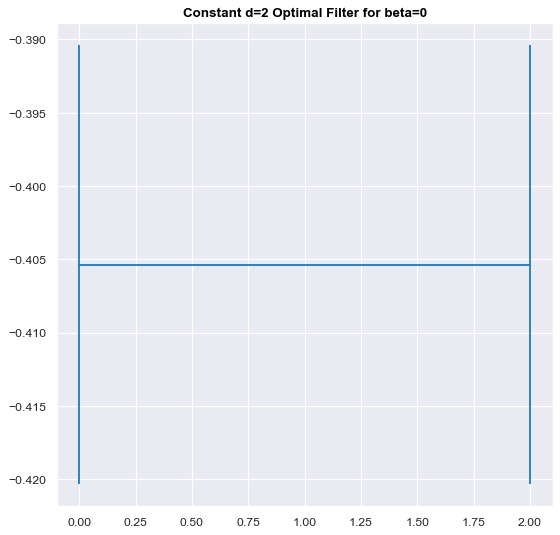

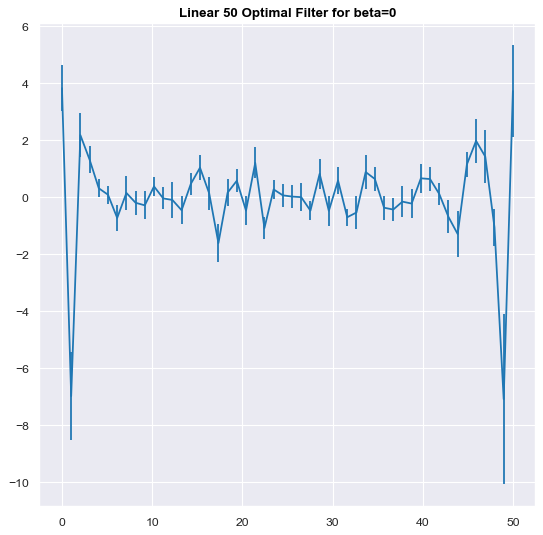

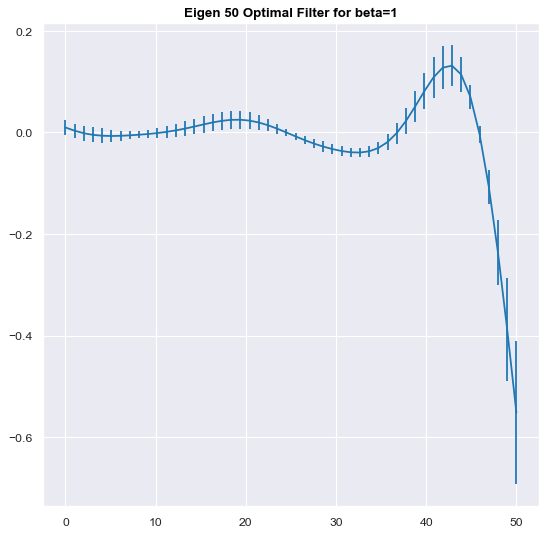

In [69]:
plot_filter(C2_Results)
plot_filter(Lin50_Results)
plot_filter(Eig50_Results)

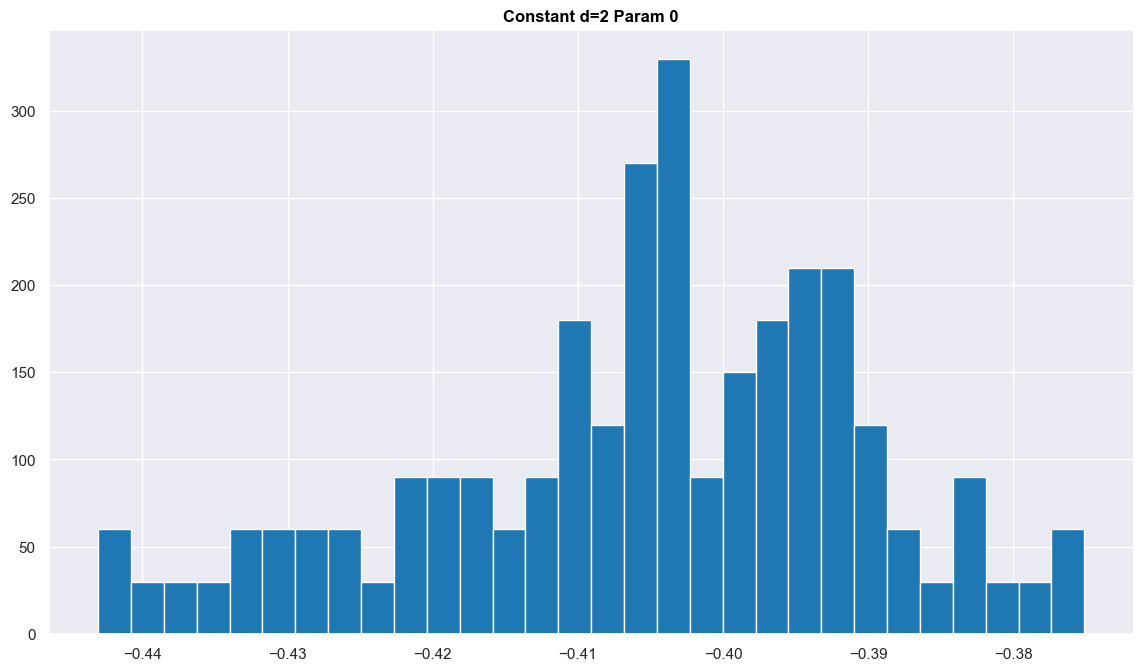

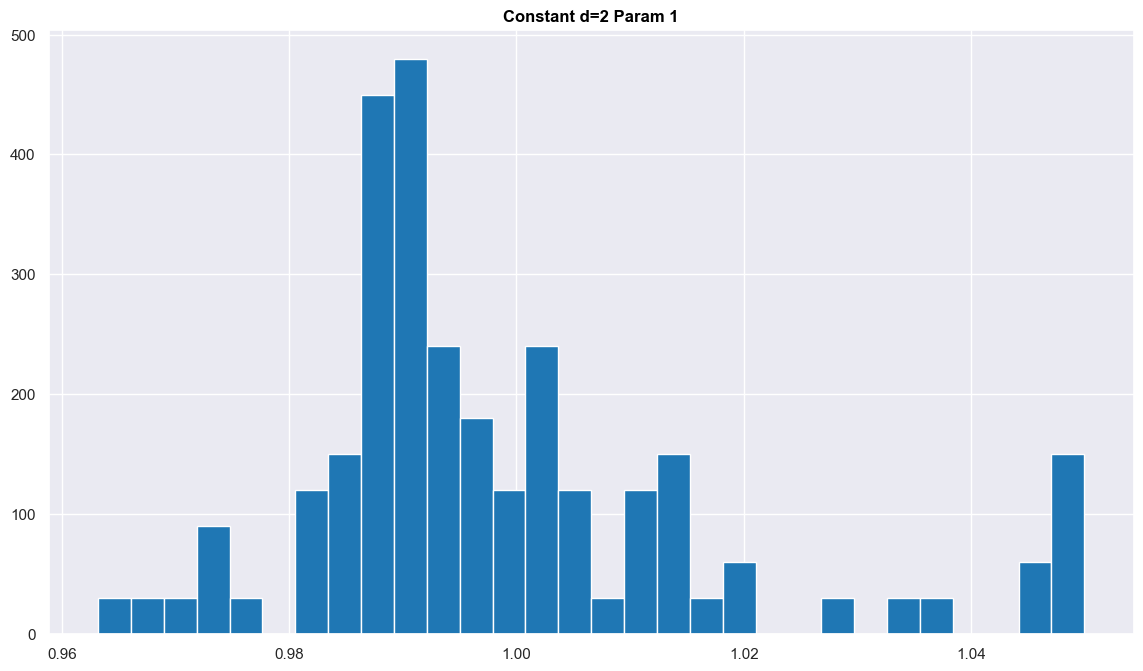

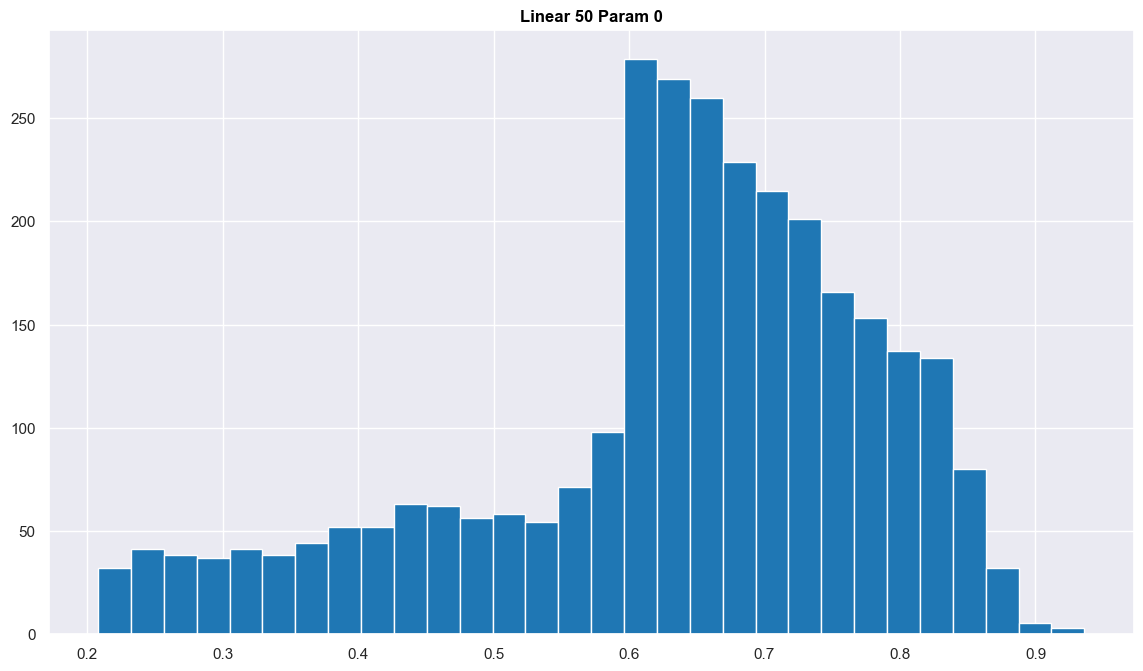

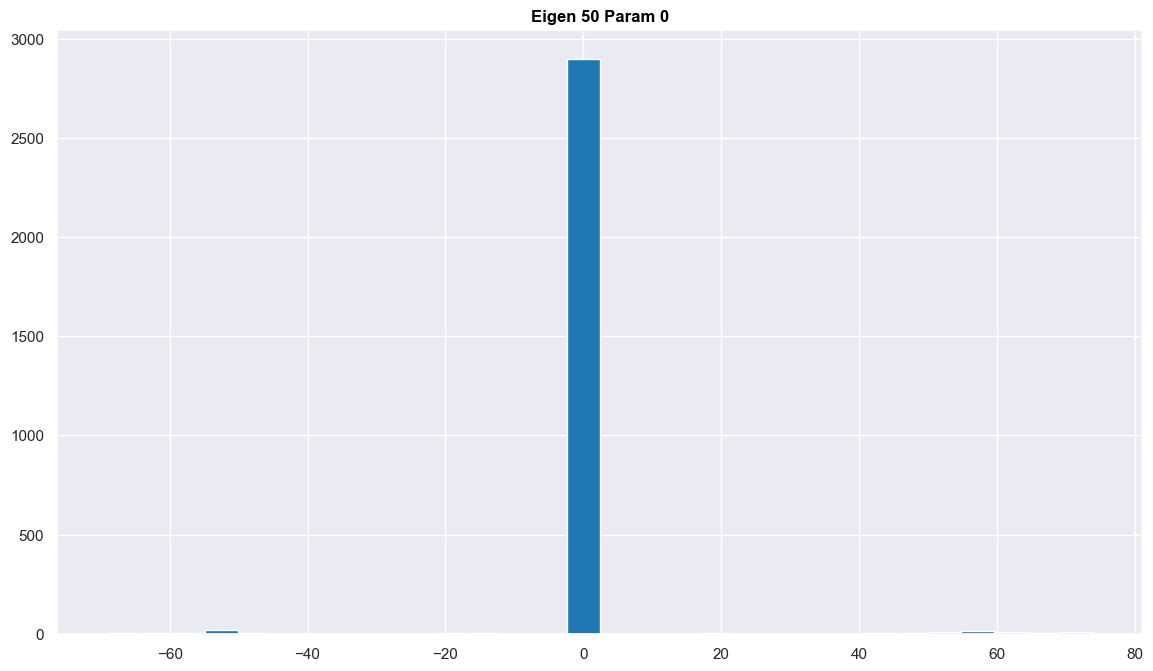

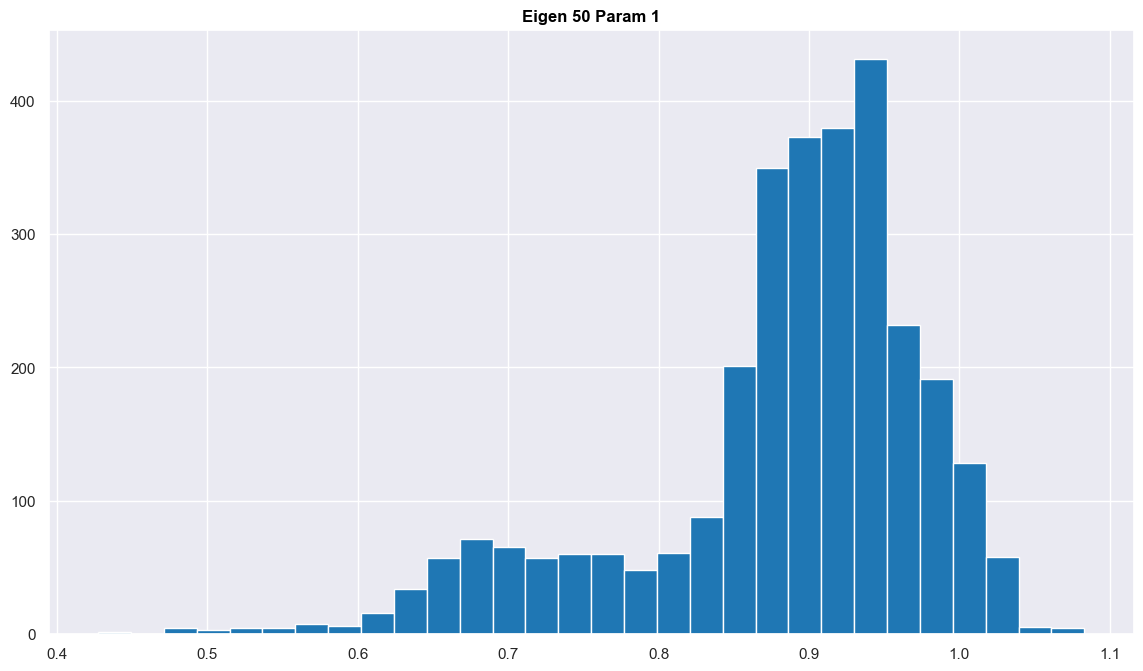

In [53]:
plot_params(C2_Results)
plot_params(Lin50_Results)
plot_params(Eig50_Results)